# Importing Necessary Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import tensorflow as tf
import os
from tensorflow import keras
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dropout, Dense, GlobalAveragePooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

## Importing Dataset from Kaggle

In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle datasets download -d paultimothymooney/blood-cells

Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/blood-cells
License(s): other
  0% 0.00/108M [00:00<?, ?B/s]
100% 108M/108M [00:00<00:00, 1.40GB/s]


In [4]:
!unzip blood-cells.zip -d blood-cells

Streaming output truncated to the last 5000 lines.
  inflating: blood-cells/dataset2-master/dataset2-master/images/TRAIN/LYMPHOCYTE/_9_8050.jpeg  
  inflating: blood-cells/dataset2-master/dataset2-master/images/TRAIN/LYMPHOCYTE/_9_8167.jpeg  
  inflating: blood-cells/dataset2-master/dataset2-master/images/TRAIN/LYMPHOCYTE/_9_8283.jpeg  
  inflating: blood-cells/dataset2-master/dataset2-master/images/TRAIN/LYMPHOCYTE/_9_8324.jpeg  
  inflating: blood-cells/dataset2-master/dataset2-master/images/TRAIN/LYMPHOCYTE/_9_8379.jpeg  
  inflating: blood-cells/dataset2-master/dataset2-master/images/TRAIN/LYMPHOCYTE/_9_8577.jpeg  
  inflating: blood-cells/dataset2-master/dataset2-master/images/TRAIN/LYMPHOCYTE/_9_8587.jpeg  
  inflating: blood-cells/dataset2-master/dataset2-master/images/TRAIN/LYMPHOCYTE/_9_8655.jpeg  
  inflating: blood-cells/dataset2-master/dataset2-master/images/TRAIN/LYMPHOCYTE/_9_8701.jpeg  
  inflating: blood-cells/dataset2-master/dataset2-master/images/TRAIN/LYMPHOCYTE/_9_8

## Creating DataFrame with Imagepath and Label

In [2]:
import os

In [3]:
import pandas as pd

In [4]:
Train_dir = '/home/harrypotter/Downloads/blood-cells/dataset2-master/dataset2-master/images/TRAIN'
Test_dir = '/home/harrypotter/Downloads/blood-cells/dataset2-master/dataset2-master/images/TEST'

Paths = [(Train_dir, []), (Test_dir, [])]

# Loop through each directory
for dir_path, data_list in Paths:
    for label in os.listdir(dir_path):
        label_path = os.path.join(dir_path, label)
        if os.path.isdir(label_path):
            for img_file in os.listdir(label_path):
                img_path = os.path.join(label_path, img_file)
                data_list.append([img_path, label])

Train_df = pd.DataFrame(Paths[0][1], columns=['filepath', 'label'])
Test_df = pd.DataFrame(Paths[1][1], columns=['filepath', 'label'])

print("Train:", Train_df.shape)
print("Test:", Test_df.shape)

Train: (9957, 2)
Test: (2487, 2)


In [5]:
Train_df.head()

,filepath,label
0,/home/harrypotter/Downloads/blood-cells/datase...,NEUTROPHIL
1,/home/harrypotter/Downloads/blood-cells/datase...,NEUTROPHIL
2,/home/harrypotter/Downloads/blood-cells/datase...,NEUTROPHIL
3,/home/harrypotter/Downloads/blood-cells/datase...,NEUTROPHIL
4,/home/harrypotter/Downloads/blood-cells/datase...,NEUTROPHIL


## Number of Unique Classes

In [7]:
Train_df['label'].unique()

array(['MONOCYTE', 'LYMPHOCYTE', 'EOSINOPHIL', 'NEUTROPHIL'], dtype=object)

## Displaying some Images

In [14]:
def show_blood_cell_images(image_gen):
    class_indices = image_gen.class_indices
    classes = list(class_indices.keys())
    images, labels = next(image_gen)

    plt.figure(figsize=(20, 20))
    length = len(labels)
    r = min(length, 25)

    for i in range(r):
        plt.subplot(5, 5, i + 1)
        image = (images[i] + 1) / 2  # Normalize if needed
        plt.imshow(image)
        index = np.argmax(labels[i])
        class_name = classes[index]
        plt.title(class_name, color="green", fontsize=14)
        plt.axis('off')

    plt.savefig('Sample_Images.png')
    plt.show()

Found 9957 images belonging to 4 classes.


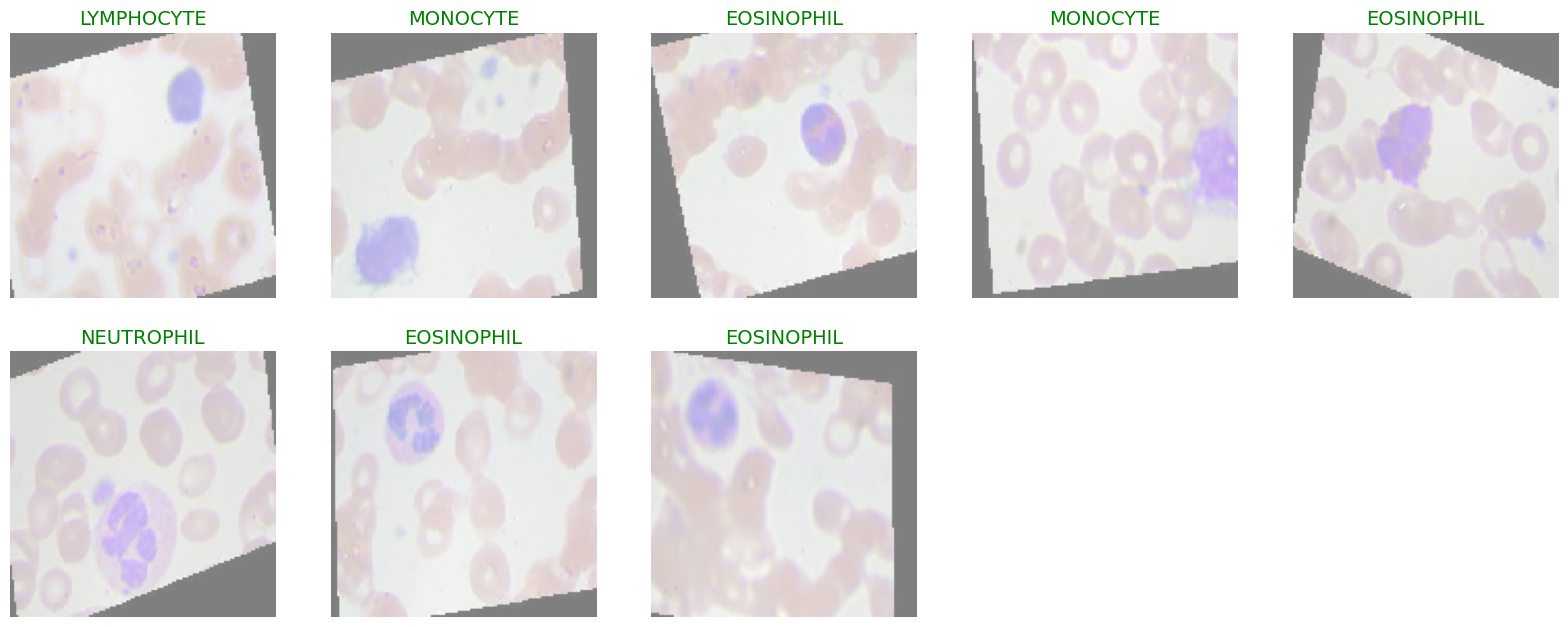

In [15]:
import matplotlib.pyplot as plt
import numpy as np

from tensorflow.keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(rescale=1./255)

train_generator = datagen.flow_from_directory(
    '/home/harrypotter/Downloads/blood-cells/dataset2-master/dataset2-master/images/TRAIN',
    target_size=(128, 128),
    batch_size=8,
    class_mode='categorical',
    shuffle=True
)

show_blood_cell_images(train_generator)

##  Image Preprocessing with Data Generators

In [10]:
IMG_SIZE = 128

train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=30,
    zoom_range=0.3,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_test_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_gen = train_datagen.flow_from_dataframe(
    dataframe=Train_df,
    x_col='filepath',
    y_col='label',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=32,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

val_gen = val_test_datagen.flow_from_dataframe(
    dataframe=Train_df,
    x_col='filepath',
    y_col='label',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=32,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

test_gen = ImageDataGenerator(rescale=1./255).flow_from_dataframe(
    dataframe=Test_df,
    x_col='filepath',
    y_col='label',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 7966 validated image filenames belonging to 4 classes.
Found 1991 validated image filenames belonging to 4 classes.
Found 2487 validated image filenames belonging to 4 classes.


## Model Training and Saving to Blood_Cell.h5

In [11]:
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
base_model.trainable = False  # Freeze initially

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dropout(0.5),
    Dense(4, activation='softmax', kernel_regularizer=l2(0.01))
])

model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

checkpoint = ModelCheckpoint('blood_cell.h5', monitor='val_accuracy', save_best_only=True, verbose=1)
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10,
    callbacks=[checkpoint, early_stop, reduce_lr],
    verbose=1
)

base_model.trainable = True
model.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

history_fine = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10,
    callbacks=[checkpoint, early_stop, reduce_lr],
    verbose=1
)

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
249/249 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - accuracy: 0.3026 - loss: 2.1228
Epoch 1: val_accuracy improved from -inf to 0.00502, saving model to blood_cell.h5


249/249 ━━━━━━━━━━━━━━━━━━━━ 60s 202ms/step - accuracy: 0.3026 - loss: 2.1223 - val_accuracy: 0.0050 - val_loss: 3.0402 - learning_rate: 1.0000e-04
Epoch 2/10
249/249 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - accuracy: 0.3434 - loss: 1.8314
Epoch 2: val_accuracy improved from 0.00502 to 0.00954, saving model to blood_cell.h5


249/249 ━━━━━━━━━━━━━━━━━━━━ 40s 159ms/step - accuracy: 0.3434 - loss: 1.8313 - val_accuracy: 0.0095 - val_loss: 2.8163 - learning_rate: 1.0000e-04
Epoch 3/10
249/249 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - accuracy: 0.3639 - loss: 1.7110
Epoch 3: val_accuracy did not improve from 0.00954
249/249 ━━━━━━━━━━━━━━━━━━━━ 39s 158ms/step - accuracy: 0.3639 - loss: 1.7108 - val_accuracy: 0.0050 - val_loss: 3.1820 - learning_rate: 1.0000e-04
Epoch 4/10
249/249 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - accuracy: 0.3795 - loss: 1.5745
Epoch 4: val_accuracy did not improve from 0.00954
249/249 ━━━━━━━━━━━━━━━━━━━━ 39s 156ms/step - accuracy: 0.3795 - loss: 1.5743 - val_accuracy: 0.0065 - val_loss: 3.0161 - learning_rate: 1.0000e-04
Epoch 5/10
249/249 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - accuracy: 0.4066 - loss: 1.4712
Epoch 5: val_accuracy improved from 0.00954 to 0.01105, saving model to blood_cell.h5



Epoch 5: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
249/249 ━━━━━━━━━━━━━━━━━━━━ 40s 161ms/step - accuracy: 0.4066 - loss: 1.4712 - val_accuracy: 0.0110 - val_loss: 2.8576 - learning_rate: 1.0000e-04
Epoch 6/10
249/249 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - accuracy: 0.4098 - loss: 1.4344
Epoch 6: val_accuracy did not improve from 0.01105
249/249 ━━━━━━━━━━━━━━━━━━━━ 39s 158ms/step - accuracy: 0.4099 - loss: 1.4344 - val_accuracy: 0.0095 - val_loss: 2.8616 - learning_rate: 5.0000e-05
Epoch 7/10
249/249 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - accuracy: 0.4244 - loss: 1.3883
Epoch 7: val_accuracy improved from 0.01105 to 0.01205, saving model to blood_cell.h5


249/249 ━━━━━━━━━━━━━━━━━━━━ 39s 157ms/step - accuracy: 0.4243 - loss: 1.3883 - val_accuracy: 0.0121 - val_loss: 2.7697 - learning_rate: 5.0000e-05
Epoch 8/10
249/249 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - accuracy: 0.4304 - loss: 1.3667
Epoch 8: val_accuracy improved from 0.01205 to 0.01306, saving model to blood_cell.h5


249/249 ━━━━━━━━━━━━━━━━━━━━ 39s 157ms/step - accuracy: 0.4304 - loss: 1.3667 - val_accuracy: 0.0131 - val_loss: 2.7161 - learning_rate: 5.0000e-05
Epoch 9/10
249/249 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - accuracy: 0.4273 - loss: 1.3597
Epoch 9: val_accuracy did not improve from 0.01306
249/249 ━━━━━━━━━━━━━━━━━━━━ 40s 160ms/step - accuracy: 0.4273 - loss: 1.3597 - val_accuracy: 0.0116 - val_loss: 2.8167 - learning_rate: 5.0000e-05
Epoch 10/10
249/249 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - accuracy: 0.4488 - loss: 1.3287
Epoch 10: val_accuracy did not improve from 0.01306
249/249 ━━━━━━━━━━━━━━━━━━━━ 40s 163ms/step - accuracy: 0.4488 - loss: 1.3287 - val_accuracy: 0.0105 - val_loss: 2.8862 - learning_rate: 5.0000e-05
Restoring model weights from the end of the best epoch: 8.
Epoch 1/10
249/249 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step - accuracy: 0.4081 - loss: 1.4055
Epoch 1: val_accuracy improved from 0.01306 to 0.03214, saving model to blood_cell.h5


249/249 ━━━━━━━━━━━━━━━━━━━━ 112s 272ms/step - accuracy: 0.4083 - loss: 1.4051 - val_accuracy: 0.0321 - val_loss: 2.8847 - learning_rate: 1.0000e-05
Epoch 2/10
249/249 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - accuracy: 0.5834 - loss: 1.0361
Epoch 2: val_accuracy improved from 0.03214 to 0.06931, saving model to blood_cell.h5


249/249 ━━━━━━━━━━━━━━━━━━━━ 44s 177ms/step - accuracy: 0.5835 - loss: 1.0358 - val_accuracy: 0.0693 - val_loss: 2.8418 - learning_rate: 1.0000e-05
Epoch 3/10
249/249 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - accuracy: 0.6870 - loss: 0.8111
Epoch 3: val_accuracy improved from 0.06931 to 0.18232, saving model to blood_cell.h5


249/249 ━━━━━━━━━━━━━━━━━━━━ 45s 182ms/step - accuracy: 0.6870 - loss: 0.8110 - val_accuracy: 0.1823 - val_loss: 2.5183 - learning_rate: 1.0000e-05
Epoch 4/10
249/249 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - accuracy: 0.7529 - loss: 0.6695
Epoch 4: val_accuracy improved from 0.18232 to 0.27926, saving model to blood_cell.h5


249/249 ━━━━━━━━━━━━━━━━━━━━ 45s 180ms/step - accuracy: 0.7530 - loss: 0.6694 - val_accuracy: 0.2793 - val_loss: 2.2158 - learning_rate: 1.0000e-05
Epoch 5/10
249/249 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - accuracy: 0.7931 - loss: 0.5789
Epoch 5: val_accuracy improved from 0.27926 to 0.40080, saving model to blood_cell.h5


249/249 ━━━━━━━━━━━━━━━━━━━━ 45s 179ms/step - accuracy: 0.7932 - loss: 0.5788 - val_accuracy: 0.4008 - val_loss: 1.7696 - learning_rate: 1.0000e-05
Epoch 6/10
249/249 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - accuracy: 0.8119 - loss: 0.5131
Epoch 6: val_accuracy improved from 0.40080 to 0.51180, saving model to blood_cell.h5


249/249 ━━━━━━━━━━━━━━━━━━━━ 45s 179ms/step - accuracy: 0.8120 - loss: 0.5130 - val_accuracy: 0.5118 - val_loss: 1.4177 - learning_rate: 1.0000e-05
Epoch 7/10
249/249 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - accuracy: 0.8556 - loss: 0.4200
Epoch 7: val_accuracy improved from 0.51180 to 0.63385, saving model to blood_cell.h5


249/249 ━━━━━━━━━━━━━━━━━━━━ 44s 176ms/step - accuracy: 0.8556 - loss: 0.4201 - val_accuracy: 0.6339 - val_loss: 1.0191 - learning_rate: 1.0000e-05
Epoch 8/10
249/249 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - accuracy: 0.8694 - loss: 0.3919
Epoch 8: val_accuracy improved from 0.63385 to 0.72325, saving model to blood_cell.h5


249/249 ━━━━━━━━━━━━━━━━━━━━ 82s 177ms/step - accuracy: 0.8694 - loss: 0.3919 - val_accuracy: 0.7233 - val_loss: 0.7910 - learning_rate: 1.0000e-05
Epoch 9/10
249/249 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - accuracy: 0.8770 - loss: 0.3676
Epoch 9: val_accuracy improved from 0.72325 to 0.78805, saving model to blood_cell.h5


249/249 ━━━━━━━━━━━━━━━━━━━━ 45s 180ms/step - accuracy: 0.8770 - loss: 0.3675 - val_accuracy: 0.7880 - val_loss: 0.5969 - learning_rate: 1.0000e-05
Epoch 10/10
249/249 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - accuracy: 0.8755 - loss: 0.3683
Epoch 10: val_accuracy improved from 0.78805 to 0.83375, saving model to blood_cell.h5


249/249 ━━━━━━━━━━━━━━━━━━━━ 45s 180ms/step - accuracy: 0.8755 - loss: 0.3682 - val_accuracy: 0.8338 - val_loss: 0.4406 - learning_rate: 1.0000e-05
Restoring model weights from the end of the best epoch: 10.


# Model Architecture

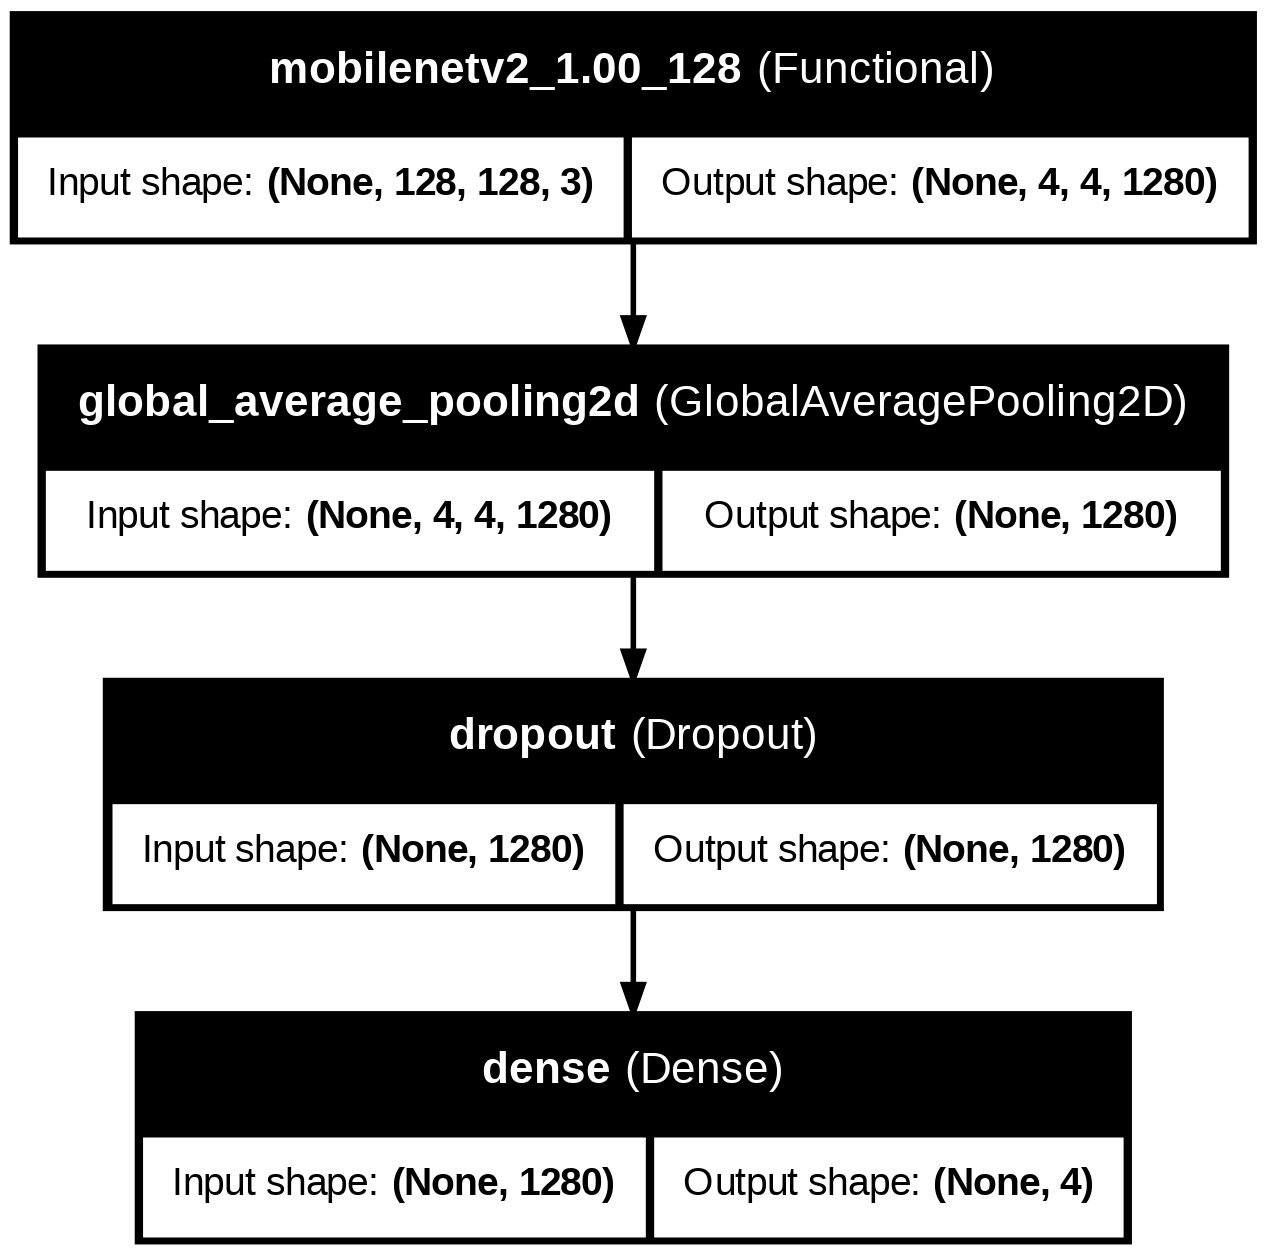

In [12]:
from tensorflow.keras.utils import plot_model

plot_model(model, to_file='model_architecture.png', show_shapes=True, show_layer_names=True)

## Evaluating Model Performance on Test Data

In [13]:
model = load_model('blood_cell.h5')

test_loss, test_accuracy = model.evaluate(test_gen)
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


78/78 ━━━━━━━━━━━━━━━━━━━━ 11s 96ms/step - accuracy: 0.8968 - loss: 0.3432
Test Accuracy: 0.8496
Test Loss: 0.4812


## Plotting Model Accuracy and Loss

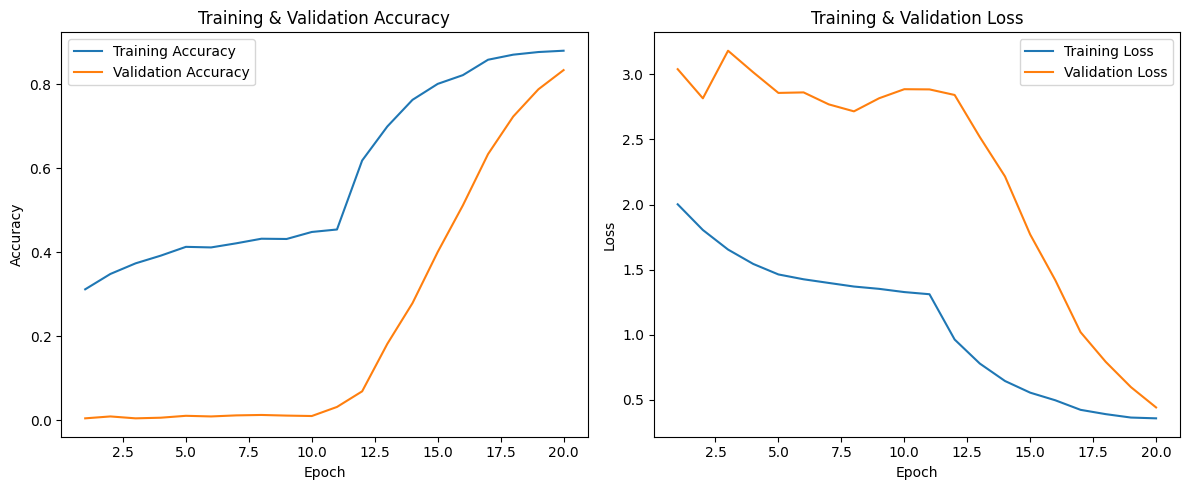

In [14]:
acc = history.history['accuracy'] + history_fine.history['accuracy']
val_acc = history.history['val_accuracy'] + history_fine.history['val_accuracy']
loss = history.history['loss'] + history_fine.history['loss']
val_loss = history.history['val_loss'] + history_fine.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12, 5))

# Plot Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs, acc,  label='Training Accuracy')
plt.plot(epochs, val_acc,  label='Validation Accuracy')
plt.title('Training & Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss,  label='Training Loss')
plt.plot(epochs, val_loss,  label='Validation Loss')
plt.title('Training & Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.savefig('training_plot.png')
plt.show()


# Classification Report

In [15]:
y_test = test_gen.labels

pred2 = model.predict(test_gen)
pred2 = np.argmax(pred2, axis=1)

print(classification_report(y_test, pred2, target_names=test_gen.class_indices.keys()))
print("Accuracy of the Model:", "{:.1f}%".format(accuracy_score(y_test, pred2) * 100))

78/78 ━━━━━━━━━━━━━━━━━━━━ 9s 73ms/step
              precision    recall  f1-score   support

  EOSINOPHIL       0.92      0.65      0.76       623
  LYMPHOCYTE       0.85      1.00      0.92       620
    MONOCYTE       0.90      0.91      0.90       620
  NEUTROPHIL       0.76      0.85      0.80       624

    accuracy                           0.85      2487
   macro avg       0.86      0.85      0.85      2487
weighted avg       0.86      0.85      0.85      2487

Accuracy of the Model: 85.0%


# Confusion Matrix

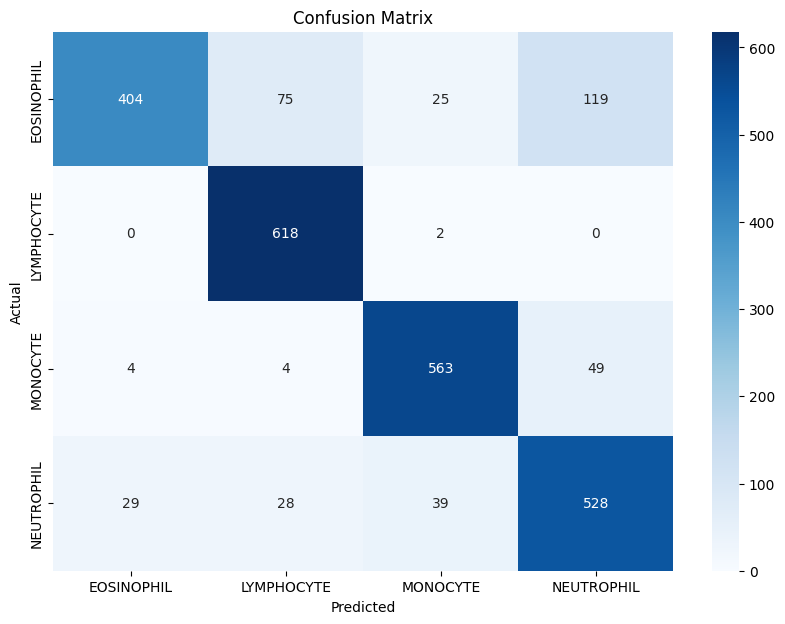

In [16]:
class_labels = list(test_gen.class_indices.keys())
cm = confusion_matrix(y_test, pred2)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels)

plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.savefig('Confusion_Matrix.png')
plt.show()

## Downloading Model saved as Blood_Cell.h5

In [17]:
# from google.colab import files
# files.download('blood_cell.h5')